This code is adapted from https://github.com/ovkoert/cz-index by O. van Koert

In [1]:
import heyoka as hy
import numpy as np
import sympy as sy
from sympy import symbols, lambdify
from sympy.parsing.sympy_parser import parse_expr
import scipy
import copy

import matplotlib.pyplot as plt

## Spaths Library

In [2]:
"""
Variables and functions for symplectic forms and pairing
"""
def get_omega0(dim):
    J0 = np.zeros((dim, dim))
    J0[dim//2:dim,0:dim//2] = np.identity(dim//2)
    J0[0:dim//2,dim//2:dim] = -np.identity(dim//2)
    return J0

eps = 1e-5
Omega6 = get_omega0(6)
Omega4 = get_omega0(4)

def dot(v, w):
    return np.sum(v * w)

def sdot4(v, w):
    return np.sum(v * (Omega4 @ w) )

def sdot6(v, w):
    return np.sum(v * (Omega6 @ w) )



def retract_sympl_path(path) -> np.array:
    r"""Retracts a symplectic path onto U(n), and takes its determinant

    Parameters
    ----------
    path : numpy.array
    Array with shape (N,2n,2n)

    Returns
    -------
    numpy.array
    Array containing the path of complex determinants 
    """
    N = len(path)
    dim = path.shape[1]
    e_vals = np.zeros(path.shape)
    for i in range(N):
        Ah = np.asarray(path[i], dtype=float) #np.float128)
        V, Sigma, W = scipy.linalg.svd(Ah)
        e_vals[i] = np.asarray(V @ W, dtype=float)
    cdets = np.zeros(N, dtype=complex)
    for i in range(N):
        det = (np.linalg.det(e_vals[i][0:dim//2,0:dim//2]+1j * e_vals[i][dim//2:dim,0:dim//2] ))
        cdets[i] = det
    return cdets



def iwasawa(S):
    r"""Returns Iwasawa decomposition of a symplectic matrix, following 

    Parameters
    ----------
    path : numpy.array
    Array with shape (2n,2n)

    Returns
    -------
    numpy.array
    array with shape (2n,2n) containing K-part
    numpy.array
    array with shape (2n,2n) containing A-part
    numpy.array
    array with shape (2n,2n) containing N-part
    """
    dim = len(S)
    n = dim // 2
    S1 = S[:, 0:n]
    Q, R = np.linalg.qr(S1)
    H = np.zeros((n,n))
    for i in range(n):
        H[i, i] = 1 / R[i, i]
    U = H @ R 
    D = np.zeros((n,n))
    sD = np.zeros((n,n))
    sD_inv = np.zeros((n,n))
    for i in range(n):
        H[i, i] = R[i, i]
        D[i, i] = R[i, i] * R[i, i]
        sD[i,i] = np.sqrt(D[i, i])
        sD_inv[i,i] = 1 / sD[i,i]
    A = np.zeros((dim, dim))
    A[0:n,0:n] = sD 
    A[n:dim,n:dim] = sD_inv
    K = np.zeros((dim, dim))
    K[0:n, 0:n] = Q[0:n,0:n] @ H @ sD_inv 
    K[0:n, n:dim] = -Q[n:dim,0:n] @ H @ sD_inv
    K[n:dim, n:dim] = K[0:n, 0:n]
    K[n:dim, 0:n] = -K[0:n, n:dim]
    N = np.zeros((dim, dim))
    N[0:n, 0:n] = U 
    N[:, n:dim] = np.linalg.inv(A) @ (K.transpose() @ S[:,n:dim])
    return K, A, N



def KtoU(K):
    r"""Converts 2n by 2n U(n) matrix to n by n complex form

    Parameters
    ----------
    path : numpy.array
    Array with shape (2n,2n)

    Returns
    -------
    numpy.array
    array with shape (n,n) containing U(n) matrix
    """
    n = len(K) // 2
    #U = np.zeros((n,n), dtype=complex)
    U = K[0:n,0:n] -1j * K[n:2*n,0:n]
    return U 



def UtoK(U):
    """Converts n by n U(n) matrix to 2n by 2n real form

    Parameters
    ----------
    path : numpy.array
    Array with shape (n,n)

    Returns
    -------
    numpy.array
    array with shape (2n,2n) containing U(n) matrix
    in real form
    """
    n = len(U)
    K = np.zeros((2*n,2*n))
    K[0:n,0:n] = np.real(U)
    K[n:2*n,n:2*n] = np.real(U)
    K[n:2*n,0:n] = -np.imag(U)
    K[0:n,n:2*n] = +np.imag(U)
    return K

def maslov_func(S):
    """Returns the value of the Maslov function det(id-S)

    Parameters
    ----------
    S : numpy.array
    Array with shape (2n,2n)

    Returns
    -------
    float
    """
    return np.linalg.det(np.identity(4)-S)





"""Functions for dealing with elliptic matrices
These are symplectic matrices with eigenvalues on the unit circle.

"""


""" n by n U(n) matrix to 2n by 2n real form

Parameters
----------
path : numpy.array
    Array with shape (n,n)

Returns
-------
numpy.array
    array with shape (2n,2n) containing U(n) matrix
    in real form
"""




def find_elliptic_pairs(S):
    """Returns the elliptic pairs of eigenvalues of a symplectic matrix S.
    Since elliptic pairs are supposed to be on the unit circle and not degenerate,
    we discard values that are further away than eps

    Parameters
    ----------
    S : numpy.array
    Array with shape (2n,2n)

    Returns
    -------
    Tuple consisting of a list with the indices of the elliptic pairs,
    a numpy array with the eigenvalues, and 
    a numpy array with the basis change (from diagonalization)
    """
    eigvals, B = np.linalg.eig(S)
    c_pairs = []
    indices = []
    for i in range(len(eigvals)):
        eigval = eigvals[i]
        if np.abs(eigval-1) < eps or np.abs(eigval+1)< eps or np.abs(np.abs(eigval)-1) > eps or i in indices:
            continue
        for j in range(i + 1,len(eigvals)):
            if np.abs( np.conjugate(eigvals[j]) - eigval ) < eps:
                indices.append(i)
                indices.append(j)
                c_pairs.append([i,j])
                break
    return c_pairs, eigvals, B



def path_removing_elliptic_pairs(S, steps=200):
    """Returns path of symplectic matrices starting at S and ending at S', where
    S' has no elliptic pairs left

    Parameters
    ----------
    S : numpy.array
    Array with shape (2n,2n)
    steps : int
    
    Returns
    -------
    path : numpy.array with shape (steps, 2n, 2n)
    """
    c_pairs, eigvals, B = find_elliptic_pairs(S)
    if len(c_pairs) == 0:
        return np.array( [S for i in range(steps)])
    path = np.zeros((steps, 4, 4), dtype=complex)
    angle_paths = []
    for pair in c_pairs:
        eigval = eigvals[pair[0]]
        angle = np.arctan2(np.imag(eigval), np.real(eigval))
        Binv = np.linalg.inv(B)
        angle_paths.append(np.exp(np.linspace(angle * 1j, np.pi * 1j, steps) ) )
    angle_paths = np.asarray(angle_paths)
    for s in range(steps):
        lst = np.array(eigvals)
        for idx, pair in enumerate(c_pairs):
            lst[pair[0]] = angle_paths[idx][s]
            lst[pair[1]] = np.conjugate(angle_paths[idx][s])
        diag_s = np.diag(lst)
        path[s] = B @ diag_s @ Binv
    return np.real(path)





"""Functions for dealing with hyperbolic matrices
These are symplectic matrices with eigenvalues in norm greater or less than 1,
"""

def find_real_hyperbolic_pairs(S):
    """Returns the pairs of real eigenvalues of a symplectic matrix S.
    Eigenvalues with imaginary part larger than eps, or eigenvalues that are closer
    than eps to 1 are discarded.

    Parameters
    ----------
    S : numpy.array
    Array with shape (2n,2n)

    Returns
    -------
    Tuple consisting of a list with the indices of real hyperbolic pairs,
    a numpy array with the eigenvalues, and 
    a numpy array with the basis change (from diagonalization)
    """
    eigvals, B = np.linalg.eig(S)
    eigvals = [np.real(val) if np.abs(np.imag(val) ) < eps else val for val in eigvals]
    c_pairs = []
    indices = []
    for i in range(len(eigvals)):
        eigval = eigvals[i]
        if np.abs(np.real(eigval) - eigval) > eps or np.abs(eigval+1)< eps or np.abs(eigval-1)< eps or i in indices:
            continue
        for j in range(i + 1,len(eigvals)):
            if np.abs( 1 / eigvals[j] - eigval ) < eps:
                indices.append(i)
                indices.append(j)
                c_pairs.append([i, j])
                break   
    return c_pairs, eigvals, B


def path_removing_negative_hyperbolic_pairs(S, steps=200):
    r"""Returns path of symplectic matrices starting at S and ending at S', where
    S' has no negative real hyperbolic pairs left

    Parameters
    ----------
    S : numpy.array
    Array with shape (2n,2n)
    steps : int
    
    Returns
    -------
    path : numpy.array with shape (steps, 2n, 2n)
    """
    c_pairs, eigvals, B = find_real_hyperbolic_pairs(S)
    eigvals = [np.real(val) if np.abs(np.imag(val) ) < eps else val for val in eigvals]
    if len(c_pairs) == 0:
        return np.array( [S for i in range(steps)])
    
    path = np.zeros((steps, 4, 4), dtype=complex)
    eigenval_paths = []
    Binv = np.linalg.inv(B)
    for pair in c_pairs:
        eigval = eigvals[pair[0]]
        if eigval < 0:
            eigenval_paths.append(np.linspace(eigval, -1.0, steps))
        else:
            eigenval_paths.append(np.linspace(eigval, eigval, steps))
    eigenval_paths = np.asarray(eigenval_paths)
    for s in range(steps):
        lst = np.array(eigvals)
        for idx, pair in enumerate(c_pairs):
            lst[pair[0]] = eigenval_paths[idx][s]
            lst[pair[1]] = 1.0 / eigenval_paths[idx][s]
        diag_s = np.diag(lst)
        path[s] = B @ diag_s @ Binv
    return path





def find_complex_hyperbolic_tuple(S):
    r"""Returns a tuple of complex eigenvalues of a symplectic matrix S 
    that do not lie on the unit circle. Eigenvalues that are closer 
    than eps to the unit circle are discarded.

    Parameters
    ----------
    S : numpy.array
    Array with shape (2n,2n)

    Returns
    -------
    Tuple consisting of a list with the indices of complex hyperbolic eigenvalues,
    a numpy array with the eigenvalues, and 
    a numpy array with the basis change (from diagonalization)
    """
    eigvals, B = np.linalg.eig(S)
    c_pairs = []
    for i in range(len(eigvals)):
        eigval = eigvals[i]
        if np.abs(np.real(eigval) - eigval) < eps or np.abs(np.abs(eigval)-1) < eps:
            continue
        c_pairs.append(i)
        #inverse
        for j in range(i + 1,len(eigvals)):
            if np.abs( 1 / eigvals[j] - eigval ) < eps:
                c_pairs.append(j)
                break
        #conjugate
        for j in range(i + 1,len(eigvals)):
            if np.abs( np.conjugate(eigvals[j]) - eigval ) < eps:
                c_pairs.append(j)
                break
        #conjugate inverse
        for j in range(i + 1,len(eigvals)):
            if np.abs( 1 / np.conjugate(eigvals[j]) - eigval ) < eps:
                c_pairs.append(j)
                break
        #pair_found = True
        break
    return c_pairs, eigvals,B



def path_removing_cpx_hyp_tuple(S, steps=200):
    r"""Returns path of symplectic matrices starting at S and ending at S', 
    where S' has no complex hyperbolic eigenvalues left

    Parameters
    ----------
    S : numpy.array
    Array with shape (2n,2n)
    steps : int
    
    Returns
    -------
    path : numpy.array with shape (steps, 2n, 2n)
    """
    tuple, eigvals, B = find_complex_hyperbolic_tuple(S)
    if len(tuple) < 4:
        return np.array( [S for i in range(steps)])
    eigval = eigvals[tuple[0]]
    norm = np.linalg.norm(eigval)
    angle = np.arctan2(np.imag(eigval), np.real(eigval))
    path = np.zeros((steps, 4, 4), dtype=complex)
    Binv = np.linalg.inv(B)
    angle_path = np.exp(np.linspace(angle * 1j, np.pi * 1j, steps) )
    norm_path = np.linspace(norm, 1.0, steps)
    for s in range(steps):
        lst = np.array(eigvals)
        lst[tuple[0]] = norm_path[s] * angle_path[s]
        lst[tuple[1]] = 1 / (norm_path[s] * angle_path[s])
        lst[tuple[2]] = norm_path[s] * np.conjugate(angle_path[s] )
        lst[tuple[3]] = 1 / ( norm_path[s] * np.conjugate(angle_path[s]) )
        diag_s = np.diag(lst)
        path[s] = B @ diag_s @ Binv
    return np.real(path)




def rotate4(phi):
    c = np.cos(phi)
    s = np.sin(phi)
    R = np.array([[c, -s, 0, 0],
                  [s, c, 0, 0],
                  [0, 0, c, -s],
                  [0, 0, s, c]])
    return R

def change_order_mat(B, target_order):
    P = np.zeros((4, 4))
    for i in range(4):
        P[i, target_order[i]] = 1.0
    return P

def ordering_values(vals):
    sorted_vals = sorted(copy.deepcopy(vals), reverse=True)
    ordering = []
    for val in vals:
        for i in range(len(vals)):
            if sorted_vals[i] == val:
                ordering.append(i)
    return ordering, sorted_vals

def path_removing_positive_hyperbolic_tuple(S, steps=200):
    c_pairs, eigvals, B = find_real_hyperbolic_pairs(S)
    eigvals = [np.real(val) if np.abs(np.imag(val) ) < eps else val for val in eigvals]
    if len(c_pairs) < 2 or np.min(np.real(eigvals) ) < 0:
        return path_removing_cpx_hyp_tuple(S, steps=steps)
    ordering, eigvals = ordering_values(eigvals)
    O = np.zeros((4, 4))
    O[ordering[0],0] = 1
    O[ordering[3],2] = 1
    O[ordering[1],1] = 1
    O[ordering[2],3] = 1
    BO = B @ O
    BO[:,0] = -1 / sdot4(BO[:,0], BO[:,2]) * BO[:,0]
    BO[:,1] = -1 / sdot4(BO[:,1], BO[:,3]) * BO[:,1]
    BOi = np.linalg.inv(BO)
    ODO = np.linalg.inv(O) @ np.diag(eigvals) @ O
    ts = np.linspace(0.0, 1.0, steps)
    lambda_s = np.linspace(ODO[0,0], 2.0, steps)
    mu_s = np.linspace(ODO[1,1], 2.0, steps)
    path1 = np.asarray([BO @ np.diag([ls,ms,1/ls,1/ms]) @ BOi for ls, ms in zip(lambda_s,mu_s)])
    path2 = np.asarray([BO @ rotate4(0.1*s) @ np.diag([2.0,2.0,0.5,0.5]) @ BOi for s in ts])
    path3 = path_removing_cpx_hyp_tuple(path2[-1], steps=steps)
    return np.concatenate((path1, path2, path3))


def reduce_symplectic_matrix(S, steps=200):
    path2H = path_removing_positive_hyperbolic_tuple(S, steps=steps)
    pathE = path_removing_elliptic_pairs(path2H[-1], steps=steps)
    pathH = path_removing_negative_hyperbolic_pairs(pathE[-1], steps=steps)
    path = np.concatenate((path2H, pathE, pathH))
    return path 



def interpolate_K(K, dim, steps):
    U = KtoU(K)
    eigU, basis = np.linalg.eig(U)
    basis_inv = np.linalg.inv(basis)
    angles = (np.log(eigU))
    target_angles = [0.0 for el in angles]
    diags = np.linspace(angles, target_angles, steps) 
    Ks = np.zeros((steps, dim, dim))
    for idx, diag in enumerate(diags):
        Us = np.diag(np.exp(diag))
        tmp = basis @ Us @ basis_inv
        Ks[idx] = UtoK(tmp)
    return Ks


def interpolate_A(A, dim, steps):
    As = np.zeros((steps, dim, dim))
    n = dim // 2
    A_target = np.identity(n)
    A11_lin = np.linspace( A[0:n,0:n], A_target, steps)
    for step in range(steps):
        As[step][0:n,0:n] = A11_lin[step]
        As[step][n:dim,n:dim] = np.linalg.inv(A11_lin[step])
    return As

def interpolate_N(N, dim, steps):
    n = dim // 2
    Ns = np.zeros((steps, dim, dim))    
    N12_lin = np.linspace(N[0:n,n:dim], np.zeros((n,n)), steps//2)
    for step in range(steps//2):
        Ns[step][0:n,0:n] = N[0:n,0:n]
        Ns[step][n:dim,n:dim] = N[n:dim,n:dim]
        Ns[step][0:n,n:dim] = N12_lin[step]
    N_lin = np.linspace(Ns[steps//2-1], np.identity(dim), steps-steps//2)
    for step in range(steps//2, steps):
        Ns[step] = N_lin[step - steps//2]
    return Ns



def path_hyperbolic_basepoint(S, steps=200):
    c_pairs, eigvals, B = find_real_hyperbolic_pairs(S)
    if len(c_pairs) != 1:
        return np.asarray([S])
    pair = c_pairs[0]
    B1 = copy.deepcopy(B)
    B1[:,pair[0]] /= -np.dot(B[:,pair[0]], Omega4 @ B[:,pair[1]] )
    other_pair = [0, 1, 2, 3]
    for el in pair:
        other_pair.remove(el)
    B1[:,other_pair[0]] /= -np.dot(B[:,other_pair[0]], Omega4 @ B[:,other_pair[1]] )
    B1 = np.real(B1)
    idx_order = [0]
    first_pair = other_pair
    second_pair = pair
    if 0 in pair:
        first_pair = pair
        second_pair = other_pair
    idx_order.append(second_pair[0])
    idx_order.append(first_pair[1])
    idx_order.append(second_pair[1])
    B2 = np.zeros((4,4))
    R = np.zeros((4,4))
    for i in range(4):
        B2[:,i] = B1[:, idx_order[i]]
        R[i,idx_order[i]] = 1.0
    Rinv = np.linalg.inv(R)
    B1 = B1 @ R 
    K, A, N = iwasawa(B1)
    Kpath = interpolate_K(K, len(K), steps)
    Apath = interpolate_A(A, len(A), steps)
    Npath = interpolate_N(N, len(N), steps)
    Bpath = np.zeros((steps, 4, 4))
    for i in range(steps):
        Bpath[i] = Kpath[i] @ Apath[i] @ Npath[i]
    Spath = np.zeros((steps, 4, 4))
    for i in range(steps):
        Bi = Bpath[i] @ Rinv
        Bi_inv = np.linalg.inv(Bi)
        Spath[i] = np.real( Bi @ np.diag(eigvals) @ Bi_inv )
    nf = Spath[-1] #normal form
    idx0 = np.argmax(nf) % 4
    idx1 = idx0 - 2
    if idx0 + 2 < 4:
        idx1 = idx0 + 2
    rot_steps = steps // 10
    eigenval_path = np.linspace(np.max(nf), 2.0, rot_steps)
    Rpath = np.zeros((rot_steps, 4, 4))
    for i in range(rot_steps):
        Rpath[i] = nf
        Rpath[i][idx0, idx0] = eigenval_path[i]
        Rpath[i][idx1, idx1] = 1.0 / eigenval_path[i]
    return np.real(np.concatenate((Spath, Rpath)) )

def compute_angular_index(cdets, T):
    angle_jumps = [np.imag(np.log(cdets[i+1] / cdets[i] )) for i in range(T-1)]
    return int(np.round(np.sum(angle_jumps) /np.pi) ), angle_jumps

def check_symplecticity(s_path):
    return [np.sum(np.abs(A.transpose() @ Omega4 @ A -Omega4) ) for A in s_path]

def check_maslov_intersections(s_path):
    return [maslov_func(s_path[i+1]) * maslov_func(s_path[i]) for i in range(len(s_path) - 1)] 

def check_continuity(s_path):
    return [np.sum(np.abs(s_path[i+1] - s_path[i] ) ) for i in range(len(s_path) - 1)]

def get_index_sympl_path(s_path, steps=20000, error_report=False):
    path_reduced = reduce_symplectic_matrix(s_path[-1], steps=steps)
    S_reduced = np.real(path_reduced[-1])
    second_path = path_hyperbolic_basepoint(S_reduced, steps=steps)
    concat_path = np.concatenate((path_reduced, second_path))
    extend_s_path = np.concatenate( (s_path, concat_path) )
    cdets = retract_sympl_path(extend_s_path)
    CZ, angle_jumps = compute_angular_index(cdets, len(cdets)-1)
    # For reliability checking
    if error_report:
        symplecticity = np.max( check_symplecticity(extend_s_path))
        extension_sign = np.min(check_maslov_intersections(concat_path))
        continuity = np.max(check_continuity(extend_s_path))
        max_angle_jump = np.max(angle_jumps)
        print("Max angle jump at ", np.argmax(angle_jumps), len(angle_jumps ), "; jump size=", max_angle_jump)
        if max_angle_jump > np.pi:
            print("Angle jump is too large: increase the number of integration steps")
        print("Error in symplecticity was at most", symplecticity)
        if extension_sign > 0:
            print("Extention stayed away from Maslov cycle; closest at value", extension_sign)
        else:
            print("Extention crossed Maslov cycle; refine number of steps, eps", extension_sign) 
        print("Error in continuity was at most", continuity, "; increase number of steps if this is too large.")
    return CZ


"""Functions for dealing with paths in Sp(2)"""

def parity_type(s_path_xi, T):
    trace = np.matrix.trace(s_path_xi[T])
    if trace < 2:
        return 1
    else: 
        return 0

def return_closest_even(v):
    n = int(np.floor(v) )
    if n%2 == 0:
        return n
    else:
        return n+1 

def return_closest_odd(v):
    n = int(np.floor(v) )
    if n%2 == 1:
        return n
    else:
        return n+1 

def return_parity_corrected(v, parity):
    n = int(np.floor(v) )
    if n%2 == parity:
        return n
    else:
        return n+1 

def compute_fractional_angular_index(cdets, T):
    angle = 0
    for i in range(T):
        delta = cdets[i+1] / cdets[i]
        angle += np.imag(np.log(delta))
    return (angle / np.pi)

def planar_index(p_path, T):
    cdets = retract_sympl_path(p_path)
    angular_idx = compute_fractional_angular_index(cdets, T)
    planar_CZ = return_parity_corrected(angular_idx, parity_type(p_path, T))
    return planar_CZ

## Computing Conley-Zehnder indices in the restricted three-body problem
We will use the Taylor integrator from the Heyoka library and use the sympy library for some symbolic computations to prepare the equations of motions. The Conley-Zehnder index will be computed using a very basic library made for this purpose, spaths.

Intuitively, the Conley-Zehnder index is a kind of winding number of the linearized flow along an orbit. This commonly used statement leaves us one detail, namely the yard stick we use to measure the winding number: the yard stick in question will be the transverse frame which we define below.
We can use other yard sticks, too, and they can be useful, too, but the transverse frame is the one needed for the papers of Frauenfelder et al.

Once we have chosen our transverse trivialization, the linearized flow will give a path of $4$-dimensional symplectic matrices (in case of the spatial problem). In other words, for an orbit of length $T$ we get a map
$$
\psi:[0,T] \to Sp(4).
$$
After that, the Conley-Zehnder index can then be defined in multiple (equivalent) ways. We will give the most suitable definition when the relevant code appears below, but we need to discuss frames before that, so this is just an heads-up.

We define the standard coordinates on phase space for usage in sympy, including coordinates for the linearization in $xs$. The symplectic form is defined in the module spaths.


In [3]:
ps = symbols('p1 p2 p3')
qs = symbols('q1 q2 q3')
tp = symbols('t_p')
xs = symbols('xq1 xq2 xq3 xp1 xp2 xp3')
mu = symbols('mu')

scoors = [qs[i] for i in range(3)]
for i in range(3):
    scoors.append(ps[i])

We define the Hamiltonian below. This time we will insert the value of $\mu$ directly. This is not necessary, but more convenient due to the interaction of sympy and Heyoka. 
We define functions to compute the gradient $DH$ and the Hamiltonian vector field $X_H$. After that we obtain the linearized equations.

In [4]:
def compute_grad_sgrad():
    XH = [sy.diff(H,ps[i]) for i in range(3)]
    for i in range(3):
        XH.append(-sy.diff(H,qs[i]))
    XH = sy.Matrix(XH)
    DH = sy.Matrix([sy.diff(H,coor) for coor in scoors])
    return DH, XH

def compute_linearized_eq(vf):
    lin_eq = []
    for i in range(len(vf)):
        comp = 0
        for j in range(len(scoors)):
            comp += (sy.diff(vf[i], scoors[j]) * xs[j])
        lin_eq.append(comp)
    return lin_eq

We now define helper functions to deal with the conversion from sympy to numpy.

In [5]:
params = [mu] 

def l_func(func, x,  k):
    x1, x2, x3, x4, x5, x6 = x
    k1 = k[0]
    xdot = func(x1, x2, x3, x4, x5, x6, k1)
    return xdot

def l_vf6(funcs, x,  k):
    x1, x2, x3, x4, x5, x6 = x
    k1 = k[0]
    xdot = [f(x1, x2, x3, x4, x5, x6, k1) for f in funcs]
    return np.asarray(xdot).reshape((6,1))

## Using Heyoka
We now start using Heyoka. We convert all the sympy expressions into Heyoka expressions:

In [6]:
q1, q2, q3 = hy.make_vars("q1", "q2", "q3")
p1, p2, p3 = hy.make_vars("p1", "p2", "p3")
xq1, xq2, xq3, xp1, xp2, xp3 = hy.make_vars("xq1", "xq2", "xq3", "xp1", "xp2", "xp3")

hcoors = [q1, q2, q3, p1, p2, p3]
h_lincoors = [xq1, xq2, xq3, xp1, xp2, xp3]

## Saturn-Enceladus (integration)
Now let's consider the Saturn-Enceladus system with the conventions from the paper by Aydin-Frauenfelder-Koh-Moreno and myself.

In [7]:
L = qs[0] * ps[1] - qs[1] * ps[0]
T = sum([ps[i]**2 for i in range(3)] ) / 2
V = -(1-mu)/sy.sqrt( (qs[0] +mu)**2 + qs[1]**2 + qs[2]**2) - mu/sy.sqrt( (qs[0] +mu-1)**2 + qs[1]**2 + qs[2]**2)

H = T - L + V

H = H.subs(mu, 1.9002485658670e-07)
DH, XH = compute_grad_sgrad()
lin_eqs = compute_linearized_eq(XH)
XH

Matrix([
[                                                                                                                                                                                                p1 + q2],
[                                                                                                                                                                                                p2 - q1],
[                                                                                                                                                                                                     p3],
[p2 + 1.900248565867e-7*(0.999999809975143 - q1)/(q2**2 + q3**2 + (q1 - 0.999999809975143)**2)**(3/2) + 0.999999809975143*(-q1 - 1.900248565867e-7)/(q2**2 + q3**2 + (q1 + 1.900248565867e-7)**2)**(3/2)],
[                                            -p1 - 0.999999809975143*q2/(q2**2 + q3**2 + (q1 + 1.900248565867e-7)**2)**(3/2) - 1.900248565867e-7*q2/(q2**2 + q3**2 + (q1 - 0.999999

In [8]:
syms_XH = [parse_expr(str(item)) for item in XH]
syms_DH = [parse_expr(str(item)) for item in DH]

params = [mu] 
XH_funcs = [lambdify(scoors + params, f) for f in syms_XH]
DH_funcs = [lambdify(scoors + params, f) for f in syms_DH]

ham_l = lambdify(scoors + params, H)

### Trivializing the complement
We now find a symplectic trivialization the tangent bundle of the phase space.
The trivialization we use here is convenient for orbits that are sufficiently close to planar. For rectilinear orbits, another trivialization has to be chosen. We have to do more than in the planar case, because quaternions only work for planar orbits. We do this by adding a correction term (to make the Us and Vs tangent to the energy surface) before following the same procedure as before.

Here we define a function computing a suitable symplectic frame for near planar orbits. It still works for nearly rectilinear Halo orbits provided the mass parameter is not too small (Saturn-Enceladus is still okay).

The matrices $I_0$, $J_0$ and $K_0$ are inspired from the 4-dimensional quaternions, but we need to extend them to 6-dimensional phase space.

In [9]:
I0 = np.zeros((6, 6))# np.asarray([[0 for i in range(6)] for j in range(6)])
I0[0:2,3:3+2] = -np.identity(2)
I0[3:3+2,0:2] = np.identity(2)

J0 = np.zeros((6, 6)) #np.asarray([[0 for i in range(6)] for j in range(6)])
J0[0,1] = -1
J0[1,0] = 1
J0[3,4] = 1
J0[4,3] = -1

K0 = I0 @ J0

def get_symplectic_frame(pt, mu0):
    XH0 = l_vf6(XH_funcs, pt, (mu0, ))
    DH0 = l_vf6(DH_funcs, pt, (mu0, ))
    sympl_inpr = sdot6(DH0, XH0)  
    Z0 = DH0 / sympl_inpr
    nDH = dot(DH0, DH0)
    
    U1 = J0 @ DH0
    inpr = dot(DH0, U1)
    U1 = U1 - (inpr / nDH) * DH0
    sympl_inpr = sdot6(Z0, U1)  
    U1 = U1 - sympl_inpr * XH0

    V1 = K0 @ DH0
    V1 = V1 - (dot(DH0, V1) / nDH) * DH0
    V1 = V1 - sdot6(Z0, V1) * XH0
    U1 /= sdot6(U1, V1)
    
    U2 = np.array([0, 0, 0, 0, 0, 1.0]).reshape((6,1))
    V2 = np.array([0, 0, 1.0, 0, 0, 0]).reshape((6,1))

    U2 -= dot(DH0, U2) / nDH * DH0
    U2 -= sdot6(Z0, U2) * XH0
    U2 -= sdot6(U1, U2) * V1
    U2 -= -sdot6(V1, U2) * U1

    V2 -= dot(DH0, V2) / nDH * DH0
    V2 -= sdot6(Z0, V2) * XH0
    V2 -= sdot6(U1, V2) * V1
    U2 -= -sdot6(V1, V2) * U1
    U2 /= sdot6(U2, V2)

    frame = [Z0, XH0, U1, V1, U2, V2]
    return frame

In [10]:
def transverse_vector(v, sbasis):
    [U1, V1, U2, V2] = sbasis
    return np.array([sdot6(v, V1), sdot6(v, V2), -sdot6(v, U1), -sdot6(v, U2)])

def get_sympl_path(outU1, outV1, outU2, outV2):
    s_path = []
    for u1, v1, u2, v2 in zip(outU1[4], outV1[4], outU2[4], outV2[4]):
        pt = u1[0:6]
        [Z0, XH0, U1, V1, U2, V2] = get_symplectic_frame(pt[0:6], mu0)
        mat = np.zeros((4,4))
        mat[:,0] = transverse_vector(u1[6:12].reshape((6,1)), [U1, V1, U2, V2])
        mat[:,1] = transverse_vector(u2[6:12].reshape((6,1)), [U1, V1, U2, V2])
        mat[:,2] = transverse_vector(v1[6:12].reshape((6,1)), [U1, V1, U2, V2])
        mat[:,3] = transverse_vector(v2[6:12].reshape((6,1)), [U1, V1, U2, V2])
        s_path.append(mat)
    return np.asarray(s_path)    

In [11]:
ODEs = [(coor, hy.from_sympy(derivative)) for coor, derivative in zip(hcoors, XH)]
for coor, derivative in zip(h_lincoors, lin_eqs):
    ODEs.append( (coor, hy.from_sympy(derivative)) )

We read the files. Make sure the directories follow the same arrangement as the repository or rename the directories.

In [12]:
old_results1 = np.load("../data/cz_example/family_green_strand1.npy")
old_results2 = np.load("../data/cz_example/family_green_strand2.npy")

planar_results1 = np.load("../data/cz_example/green_end_planar_family1.npy")
planar_results2 = np.load("../data/cz_example/green_end_planar_family2.npy")

In [22]:
print(old_results1.shape)
print(old_results2.shape)
print(planar_results1.shape)
print(planar_results2.shape)


(3707, 17)
(356, 17)
(21735, 17)
(10188, 17)


In [23]:
print(old_results1[0])
print(old_results2[0])
print(planar_results1[0])
print(planar_results2[0])


[ 1.50006032e+00  1.90024857e-07  5.40139921e+00  9.97944930e-01
  0.00000000e+00  1.56942582e-03  0.00000000e+00  9.91962662e-01
  0.00000000e+00  9.59256507e-01  9.59256507e-01 -9.73694914e-01
 -9.73694914e-01 -4.77395901e-15  1.98755942e-15 -5.47097815e-15
  2.55697002e-15]
[ 1.50006042e+00  1.90024857e-07  5.39522410e+00  9.97936740e-01
  0.00000000e+00  1.56551786e-03  0.00000000e+00  9.91981432e-01
  0.00000000e+00  8.53537039e-01  8.53537039e-01 -9.35571147e-01
 -9.35571147e-01 -4.10782519e-15  2.21220611e-15 -1.87062265e-14
 -3.43975658e-14]
[ 1.50006380e+00  1.90024857e-07  1.87524073e+00  9.98117867e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  9.88940722e-01
  0.00000000e+00  8.30543840e+00  1.20399961e-01 -4.91281110e-01
 -4.91281110e-01  4.99600361e-15  0.00000000e+00  1.39834014e-14
  0.00000000e+00]
[ 1.50007163e+00  1.90024857e-07  1.58114470e+00  9.97216071e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  9.93242038e-01
  0.00000000e+00  5.08545556e-01  5.

The data in these files is organized as follows:
* Jacobi energy $c$ in Hamiltonian conventions: recall $\Gamma =2c$
* Mass parameter $\mu$
* Period $T$
* 6 floats containing $(q_1,q_2,q_3;p_1,p_2,p_3)$
* 4 complex floats containing proxies for the eigenvalues of a crude approximation of the reduced monodromy; these values are not very accurate since they are not computed via the actual reduced monodromy. Below we will compute these values using a numerical approximation of the actual monodromy.
* 4 floats indicated the error in the return point: this should be a very small vector.

All these values are stored complex floats, although only four of them can have a non-zero imaginary part.

In [13]:
old_results1[-1,:]

array([ 1.50007240e+00+0.j        ,  1.90024857e-07+0.j        ,
        3.91204242e+00+0.j        ,  9.98330151e-01+0.j        ,
        0.00000000e+00+0.j        , -1.33513919e-91+0.j        ,
        0.00000000e+00+0.j        ,  9.88820687e-01+0.j        ,
        0.00000000e+00+0.j        ,  4.07129129e+00+0.j        ,
        2.45756037e-01+0.j        , -3.83200384e-01+0.92366523j,
       -3.83200384e-01-0.92366523j,  2.22044605e-16+0.j        ,
       -9.35980343e-79+0.j        , -8.24567065e-16+0.j        ,
        4.72668138e-78+0.j        ])

## "Green" curve
Here is the whole green curve. The point where it becomes non-degenerate is shown as the black dot (coming from the scatter plot).

The index range corresponding to the planar part will be computed below. We don't care about the approximate eigenvalues from the npy files as we will compute more accurate values below. Hence we take the real part.

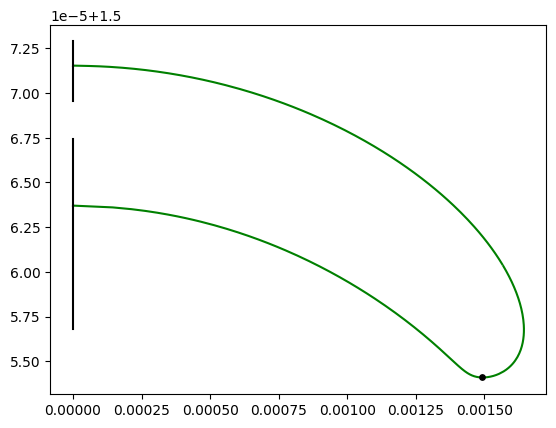

In [20]:
old_results1 = np.real(old_results1)
old_results2 = np.real(old_results2)

planar_results1 = np.real(planar_results1)
planar_results2 = np.real(planar_results2)

start_planar = list(np.where(np.abs(old_results1[:,5])<1e-10, 1, 0)).index(1)
plt.plot(old_results1[:start_planar+1,5], old_results1[:start_planar+1,0], c='g')
plt.plot(old_results1[start_planar:-50,5], old_results1[start_planar:-50,0], c='black')

start_planar = list(np.where(np.abs(old_results2[:,5])<1e-10, 1, 0)).index(1)
plt.plot(old_results2[:start_planar+1,5], old_results2[:start_planar+1,0], c='g')
plt.plot(old_results2[start_planar:,5], old_results2[start_planar:,0], c='black')

#DPO
plt.plot(planar_results1[10000:10070,5], planar_results1[10000:10070,0], c='black')

#gLPO1
plt.plot(planar_results2[10000:10020,5], planar_results2[10000:10020,0], c='black')


start_bd = np.argmin(old_results1[:,0])
end_bd = start_bd + 1
plt.scatter(old_results1[start_bd:end_bd,5], old_results1[start_bd:end_bd,0], c='black', s=15, zorder=10)

In the above we see the bifurcation graph for the spatial connection from $g-LPO1^3$ (top black segment) to $DPO^3$ (bottom black segment). We compute its starting index and end index now. Note that I am using $c=\Gamma /2$.

In [15]:
start_DPO3 = np.argmin(old_results1[:,0])
end_DPO3 = (list(np.where(old_results1[:,5]<1e-20, 1, 0)) ).index(1)
print("The DPO3 branch starts at index ", start_DPO3, " and ends at index ", end_DPO3)

The DPO3 branch starts at index  3132  and ends at index  3619


We take a  planar orbit; for the planar orbits we have the period as a simple orbit, so we need to take the three-fold cover later.

In [16]:
idx = 0
c0 = np.real(planar_results1[idx][0])
t0 = np.real(planar_results1[idx][2]) 
initial = np.real(planar_results1[idx][3:9])
mu0 = np.real(planar_results1[idx][1])

print(c0, mu0, t0)
initial = np.concatenate((initial, np.array([0.0 for i in range(6)])))
initial

1.500063801901523 1.900248565867e-07 1.875240725076029


array([0.99811787, 0.        , 0.        , 0.        , 0.98894072,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [17]:
print( "The Jacobi energy is ", l_func(ham_l, initial[0:6], (0,0)))

The Jacobi energy is  -1.5000638019015227


We now define the integrator once and run it four times with different initial conditions.

In [18]:
def compute_linearized_flow_orbit(initial, mu0, covering_number=1):
    frame = get_symplectic_frame(np.asarray(initial)[0:6], mu0)
    initial[6:12] = frame[2].reshape(6)
    ta = hy.taylor_adaptive(
        ODEs,
        initial,
        tol = 1e-18, high_accuracy = True
    )

    t_grid = np.linspace(0, covering_number * t0, 25000) ## For planar orbits we need to take the three-fold cover.
    frame = get_symplectic_frame(np.asarray(initial)[0:6], mu0)
    initial[6:12] = frame[2].reshape(6)
    ta.time = 0.0
    ta.state[:] = initial
    outU1 = ta.propagate_grid(t_grid)

    frame = get_symplectic_frame(np.asarray(initial)[0:6], mu0)
    initial[6:12] = frame[3].reshape(6)
    ta.time = 0.0
    ta.state[:] = initial
    outV1 = ta.propagate_grid(t_grid)

    frame = get_symplectic_frame(np.asarray(initial)[0:6], mu0)
    initial[6:12] = frame[4].reshape(6)
    ta.time = 0.0
    ta.state[:] = initial
    outU2 = ta.propagate_grid(t_grid)

    frame = get_symplectic_frame(np.asarray(initial)[0:6], mu0)
    initial[6:12] = frame[5].reshape(6)
    ta.time = 0.0
    ta.state[:] = initial
    outV2 = ta.propagate_grid(t_grid)
    return outU1, outV1, outU2, outV2

outU1, outV1, outU2, outV2 = compute_linearized_flow_orbit(initial, mu0, covering_number=3)

The period should be very accurate, so the following number should be very small (ideally 0, but that doesn't happen for the numerical approximation). If you get strange results later, then make sure that you take the right index here.

In [19]:
outU1[4][-1,1]

TypeError: 'NoneType' object is not subscriptable

Let's plot the orbit in top view and side view.

TypeError: 'NoneType' object is not subscriptable

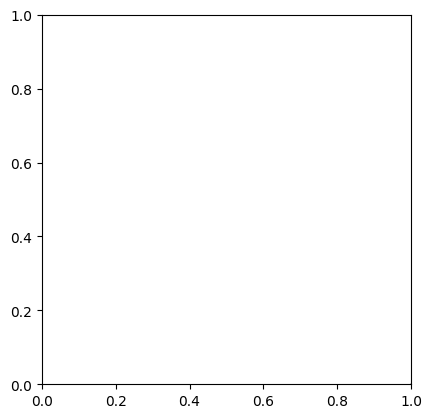

In [ ]:

rel_radius = 252.1 / 237948
ax = plt.axes()

circle1 = plt.Circle((1-mu0, 0), rel_radius, color='gray')

ax.add_patch(circle1)
#plt.plot(outU1[4][:,0], outU1[4][:,2])
plt.gca().set_aspect('equal')
plt.plot(outU1[4][:,0], outU1[4][:,1])
plt.savefig("orbit_DP3_green_top2.svg")

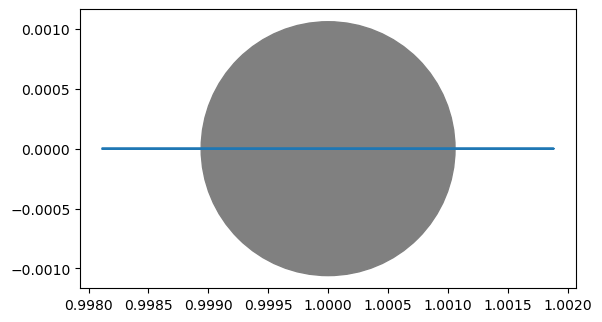

In [36]:
ax = plt.axes()
ax.plot(outU1[4][:,0], outU1[4][:,2])
circle1 = plt.Circle((1-mu0, 0), rel_radius, color='gray')

ax.add_patch(circle1)
#plt.plot(outU1[4][:,0], outU1[4][:,2])
plt.gca().set_aspect('equal')

#plt.savefig("orbit_halo_c1_5000173545779476side.svg")
plt.savefig("orbit_DPO3_green_side.svg")

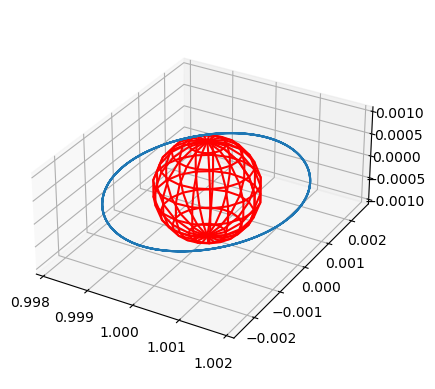

In [37]:
ax = plt.axes(projection='3d')
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')

u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = 1-mu0 + rel_radius * np.cos(u)*np.sin(v)
y = rel_radius * np.sin(u)*np.sin(v)
z = rel_radius * np.cos(v)
ax.plot_wireframe(x, y, z, color="r")
ax.plot(outU1[4][:,0], outU1[4][:,1], outU1[4][:,2])

plt.gca().set_aspect('equal')
plt.savefig("orbitDPO3_green_3d.svg")
plt.show()
plt.close()

We use the function get\_index\_orbit to get the reduced monodromy and the Conley-Zehnder index. This is done as follows:
* we get the symplectic path relative to the symplectic trivialization
* extend it 
* retract it to $U(n)$
* compute the index as a winding number. 
The function also checks reliability of the computation by checking whether the path was close to symplectic, the extension avoided the Maslov cycle and continuity of the extension. For near-collision orbits or near degenerate orbits these can be issues. To deal with these,
* the number of integrator steps and the accuracy can be increased 
* the number of discretization steps can be increased
* the threshold parameter spaths.eps can be adjusted
We found the first option to be the most typical.

In [38]:
spaths.eps = 1e-7

def get_index_orbit(idx_T, outU1, outV1, outU2, outV2, steps=20000, error_report=False):
    s_path = get_sympl_path(outU1, outV1, outU2, outV2)
    CZ = spaths.get_index_sympl_path(s_path, steps=steps, error_report=error_report)
    return CZ, s_path

In [39]:
CZ, s_path = get_index_orbit(-1, outU1, outV1, outU2, outV2, steps=1000, error_report=True)
print("The Conley-Zehnder index is", CZ)

Max angle jump at  11016 27999 ; jump size= 2.052734224682859
Error in symplecticity was at most 1.2202001420144578e-05
Extention stayed away from Maslov cycle; closest at value 0.2680919742773341
Error in continuity was at most 1236.3113891203038 ; increase number of steps if this is too large.
The Conley-Zehnder index is 13


With orbits that are close to a collision or a degeneracy, it can be difficult to get improve the continuity score, which should be small. Fortunately, even fairly big jumps will still result in the correct winding number. Problems arise when the angle jumps more than $\pi$, because then the direction of the winding cannot be determined.

Let's check the eigenvalues of the reduced monodromy.

In [40]:
np.linalg.eigvals(s_path[-1])

array([5.72911325e+02+0.j       , 1.74546528e-03+0.j       ,
       9.99546537e-01+0.0301118j, 9.99546537e-01-0.0301118j])

We can also compute the index as a planar orbit. In this case, the symplectic path splits and the Conley-Zehnder index is the sum of a planar index and a spatial index. This is actually much easier to compute, since we can drop the need for the extension. This is possible, because the behavior of the extension can be understood in a simple way.

In [41]:
def get_split_index(outU1, outV1, outU2, outV2):
    s_path = get_sympl_path(outU1, outV1, outU2, outV2)
    T = len(outU1[4]) - 1
    non_split = 0
    for i in range(0,2):
        for j in range(0,2):
            non_split += np.sum(np.abs(s_path[:, 2 * i-1, 2 * j])) + np.sum(np.abs(s_path[:, 2 * i, 2 * j-1]) ) 
    if non_split != 0.0:
        print("This symplectic path does not split: ", np.sum(non_split))
    p_path = np.zeros( (len(s_path),2,2))
    p_path[:,0,0] = s_path[:,0,0]
    p_path[:,0,1] = s_path[:,0,2]
    p_path[:,1,0] = s_path[:,2,0]
    p_path[:,1,1] = s_path[:,2,2]
    planar_CZ = planar_index(p_path, T)
    o_path = np.zeros( (len(s_path),2,2))
    o_path[:,0,0] = s_path[:,1,1]
    o_path[:,0,1] = s_path[:,1,3]
    o_path[:,1,0] = s_path[:,3,1]
    o_path[:,1,1] = s_path[:,3,3]
    out_plane_CZ = planar_index(o_path, T)
    print("Planar index = ", planar_CZ, "; out of plane index = ", out_plane_CZ, "; full index = ", planar_CZ + out_plane_CZ)

In [42]:
get_split_index(outU1, outV1, outU2, outV2)

Planar index =  6 ; out of plane index =  7 ; full index =  13


### Spatial orbit
Let's now take a spatial orbit from the family.

In [43]:
idx = 0
c0 = np.real(old_results2[idx][0])
t0 = np.real(old_results2[idx][2]) 
initial = np.real(old_results2[idx][3:9])
mu0 = np.real(planar_results1[idx][1])
print(c0, mu0, t0)
initial = np.concatenate((initial, np.array([0.0 for i in range(6)])))
initial

1.5000604213715378 1.900248565867e-07 5.395224103166016


array([0.99793674, 0.        , 0.00156552, 0.        , 0.99198143,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [44]:
outU1, outV1, outU2, outV2 = compute_linearized_flow_orbit(initial, mu0, covering_number=1)

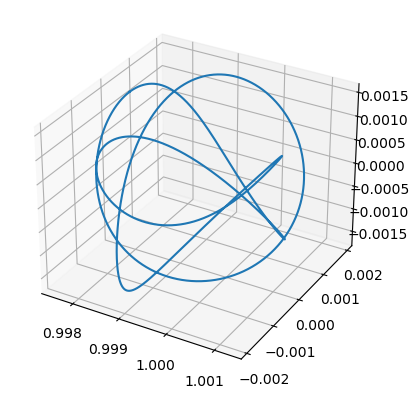

In [45]:
ax = plt.axes(projection='3d')
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.plot(outU1[4][:,0], outU1[4][:,1], outU1[4][:,2])


plt.gca().set_aspect('equal')
plt.savefig("orbit_g-LPO1_3toDPO3_green_3d.svg")
plt.show()
plt.close()

In [48]:
CZ, s_path = get_index_orbit(-1, outU1, outV1, outU2, outV2, steps=1000, error_report=True)
print("The Conley-Zehnder index is", CZ)

Max angle jump at  0 27999 ; jump size= 1.4686182588042493
Error in symplecticity was at most 5.1644417667908155e-06
Extention stayed away from Maslov cycle; closest at value 1.75542323941942
Error in continuity was at most 144.6743864104259 ; increase number of steps if this is too large.
The Conley-Zehnder index is 14


We check the eigenvalues of the reduced monodromy, and see that this is an $\mathcal E^2$-orbit (elliptic-elliptic).

In [47]:
np.linalg.eigvals(s_path[-1])

array([-0.9061238 +0.42301261j, -0.9061238 -0.42301261j,
        0.82622799+0.56333588j,  0.82622799-0.56333588j])

## CZ Function

In [36]:
from orbit_generation.dataset import get_first_period_dataset, get_orbit_classes
from orbit_generation.visualize import visualize_static_orbits
import numpy as np

Import data

In [5]:
data_path = r"/orbit-generation/data/orbits_fix_1500/EM_N_fix_1500.h5"

full_data, full_orbit_df, full_labels, system_dict = get_first_period_dataset(file_path=data_path, segment_length=100)
full_data.shape

(45211, 7, 100)

Get Labels

In [15]:
orbits_id_classes = [full_orbit_df.at[index, 'id_class'] for index in full_labels]
family_labels = get_orbit_classes(orbits_id_classes)[0]
len(family_labels)

45211

Sample orbits and labels

In [43]:
def sample_orbits_and_labels(full_data, family_labels, n):
    """Sample n random orbits and their corresponding labels"""
    indices = np.random.choice(len(family_labels), size=n, replace=False)
    sampled_orbits = full_data[indices]
    sampled_labels = [family_labels[i] for i in indices]
    return sampled_orbits, sampled_labels

# Example usage with n=5
sampled_orbits, sampled_labels = sample_orbits_and_labels(full_data, family_labels, 10)
np.save('sampled_orbits.npy', sampled_orbits)
print("Sample shapes:", sampled_orbits.shape)
print("Sample labels:", sampled_labels)


Sample shapes: (10, 7, 100)
Sample labels: ['S_R21', 'S_R23', 'S_L2_V', 'S_L1_HS', 'S_R31', 'S_L4_SP', 'S_L3_A', 'S_L1_HS', 'S_L2_HS', 'S_DS']


Orbit Visualization

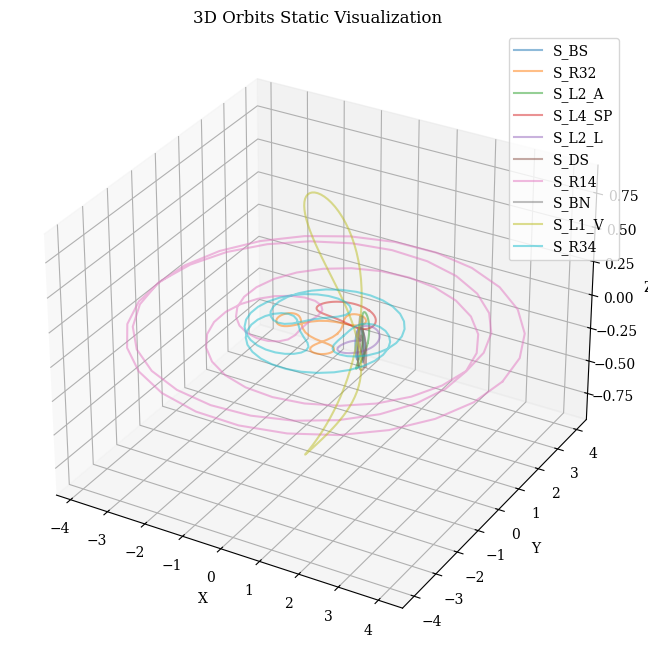

In [38]:
visualize_static_orbits(sampled_orbits, orbit_names=sampled_labels)

Initial Conditions of Orbit 0: time + position + velocity

In [44]:
single_orbit = sampled_orbits[0,:,:]
single_orbit.shape

(7, 100)

In [46]:
single_orbit[:,0]

array([ 0.0000000e+00,  3.9289168e-01,  2.8712237e-20,  1.0282888e-23,
       -7.8306265e-14,  1.4117143e+00, -3.6961712e-23], dtype=float32)

Desired Function Structure

In [ ]:
def cz_index_function(single_orbit: np.ndarray): # add whatever parameters are needed
    """
    Compute the Conley-Zehnder index of a single orbit
    
    Parameters:
        single_orbit (np.ndarray): Array containing orbit data
    """

    return cz_index